In [1]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor
import os

In [2]:
X_train_scaled = joblib.load("models/X_train_scaled.pkl")
X_val_scaled   = joblib.load("models/X_val_scaled.pkl")
X_test_scaled  = joblib.load("models/X_test_scaled.pkl")

y_train = joblib.load("models/y_train.pkl")
y_val   = joblib.load("models/y_val.pkl")
y_test  = joblib.load("models/y_test.pkl")

MLP modelleri gradyan tabanlı çalıştığı için, hedef değişkenin ölçeklenmesi öğrenme sürecini kolaylaştırır. Aşağıda StandardScaler ile bu işlem yapılmıştır. Model çıktılarını yorumlayabilmek için scaler ayrıca kaydedilir.

In [3]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))

joblib.dump(y_scaler, "models/y_scaler.pkl")


['models/y_scaler.pkl']

Aşağıda yer alan bölümde, MLP modelinin hiperparametreleri RandomizedSearchCV ve TimeSeriesSplit kullanılarak optimize edilmektedir.

In [6]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

#model yapılanırdma
def build_model(hidden_units=(128, 64, 32), dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    
    for units in hidden_units:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Linear çıkış
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# earlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# search alanı hiperparametre  optimizasyonu için
param_dist = {
    "model__hidden_units": [(128, 64, 32), (64, 32), (128, 128), (64, 64, 32)],
    "model__dropout_rate": [0.1, 0.2, 0.3],
    "model__learning_rate": [1e-3, 5e-4, 1e-4],
    "batch_size": [32, 64, 128]
}

# Wrapper ve CV
reg = KerasRegressor(
    model=build_model,
    verbose=0,
    epochs=200,
    callbacks=[early_stop],
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=3)

#Random Search
random_search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train_scaled, y_train_scaled)

#en iyi model ile değerlendirme
best_model = random_search.best_estimator_.model_
val_pred_scaled = best_model.predict(X_val_scaled)
val_pred = y_scaler.inverse_transform(val_pred_scaled)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print("En iyi hiperparametreler:")
print(random_search.best_params_)
print(f"ptimize edilmiş model RMSE (orijinal ölçekte): {rmse:.2f}")

# Kayıt
best_model.save("models/mlp_model_tuned.keras")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\90537\anaconda3\envs\tf-env\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
En iyi hiperparametreler:
{'model__learning_rate': 0.0005, 'model__hidden_units': (128, 128), 'model__dropout_rate': 0.3, 'batch_size': 64}
ptimize edilmiş model RMSE (orijinal ölçekte): 4051751.29


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name="Model"):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    corr = np.corrcoef(y_true, y_pred)[0, 1]

    print(f"\n{model_name} Değerlendirme Metrikleri:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"SMAPE: {smape:.2f}%")
    print(f"Pearson Corr: {corr:.4f}")


In [8]:

val_pred_scaled = model.predict(X_val_scaled)#model tahmini

#uç tahmin maskesi kullanıyoruz verimi arttırmak için
bad_mask = (val_pred_scaled > 1e3) | (val_pred_scaled < -1e3)

val_pred_clean = val_pred_scaled[~bad_mask.flatten()]
y_val_clean_mlp = y_val.values[~bad_mask.flatten()]

#ters dönüşüm
val_pred_mlp = y_scaler.inverse_transform(val_pred_clean)

#değerlendirme
evaluate_model(y_val_clean_mlp, val_pred_mlp, model_name="MLP (Clean)")


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

MLP (Clean) Değerlendirme Metrikleri:
MAE: 2.25
RMSE: 3.04
R²: 0.9504
MAPE: 4.66%
SMAPE: 4.48%
Pearson Corr: 0.9763


In [9]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np

In [10]:
X_train = joblib.load("models/X_train.pkl")
X_val   = joblib.load("models/X_val.pkl")
y_train = joblib.load("models/y_train.pkl")
y_val   = joblib.load("models/y_val.pkl")

In [11]:
#model tanımı
lgbm = LGBMRegressor(random_state=42)

In [12]:
# Hiperparametre arama için liste
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [13]:
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [14]:
search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26549
[LightGBM] [Info] Number of data points in the train set: 25386, number of used features: 126
[LightGBM] [Info] Start training from score 55.589005


,estimator,LGBMRegressor(random_state=42)
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 5, ...], 'min_child_samples': [10, 20, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [15]:
#orijinal ölçekte validation tahmini ve RMSE hesaplama
best_lgbm = search.best_estimator_
joblib.dump(best_lgbm, "models/lgbm_model.pkl")


['models/lgbm_model.pkl']

MLP modelinden elde edilen bazı tahminler çok uç değerlere çıkabiliyor. Bu tür ekstrem tahminleri filtreleyerek değerlendirmeyi daha sağlıklı hale getirmek amacıyla basit bir eşik (threshold) uygulandı.

In [16]:
import joblib
import numpy as np

# Modeli ve verileri yükle
best_lgbm = joblib.load("models/lgbm_model.pkl")
X_val = joblib.load("models/X_val.pkl")
y_val = joblib.load("models/y_val.pkl")

# Tahmin al
val_pred = best_lgbm.predict(X_val)

# Uç tahminleri filtrele (güvenlik amaçlı)
val_pred = np.array(val_pred).reshape(-1, 1)
bad_mask = (val_pred > 1e3) | (val_pred < -1e3)

val_pred_clean_lgbm = val_pred[~bad_mask.flatten()]
y_val_clean_lgbm = y_val.values[~bad_mask.flatten()]


In [17]:
evaluate_model(y_val_clean_lgbm, val_pred_clean_lgbm, model_name="LightGBM")



LightGBM Değerlendirme Metrikleri:
MAE: 1.96
RMSE: 2.77
R²: 0.9590
MAPE: 3.94%
SMAPE: 3.83%
Pearson Corr: 0.9793


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import joblib
import numpy as np

X_train = joblib.load("models/X_train.pkl")
y_train = joblib.load("models/y_train.pkl")
X_val = joblib.load("models/X_val.pkl")
y_val = joblib.load("models/y_val.pkl")


In [19]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#hiperparametre
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


tscv = TimeSeriesSplit(n_splits=3)

# Randomized Search
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [20]:
search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [21]:
best_rf = search.best_estimator_
joblib.dump(best_rf, "models/rf_model.pkl")

print("En iyi hiperparametreler:")
print(search.best_params_)

En iyi hiperparametreler:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [22]:
best_rf = joblib.load("models/rf_model.pkl")

val_pred = best_rf.predict(X_val)
val_pred = np.array(val_pred).reshape(-1, 1)

#uç tahmin temizliği
bad_mask = (val_pred > 1e3) | (val_pred < -1e3)
val_pred_clean_rf = val_pred[~bad_mask.flatten()]
y_val_clean_rf = y_val.values[~bad_mask.flatten()]

In [23]:
evaluate_model(y_val_clean_rf, val_pred_clean_rf, model_name="Random Forest")



Random Forest Değerlendirme Metrikleri:
MAE: 2.13
RMSE: 3.03
R²: 0.9508
MAPE: 4.24%
SMAPE: 4.13%
Pearson Corr: 0.9753


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def collect_metrics(y_true, y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    corr = np.corrcoef(y_true, y_pred)[0, 1]

    return [mae, rmse, r2, mape, smape, corr]


In [25]:
mlp_metrics = collect_metrics(y_val_clean_mlp, val_pred_mlp)
lgbm_metrics = collect_metrics(y_val_clean_lgbm, val_pred_clean_lgbm)
rf_metrics   = collect_metrics(y_val_clean_rf, val_pred_clean_rf)


In [26]:
results = pd.DataFrame(
    [mlp_metrics, lgbm_metrics, rf_metrics],
    columns=["MAE", "RMSE", "R²", "MAPE (%)", "SMAPE (%)", "Pearson Corr"],
    index=["MLP (Clean)", "LightGBM (Clean)", "Random Forest (Clean)"]
)

print("\nModel Karşılaştırma Tablosu:")
display(results.round(4))



Model Karşılaştırma Tablosu:


,MAE,RMSE,R²,MAPE (%),SMAPE (%),Pearson Corr
MLP (Clean),2.2536,3.0414,0.9504,4.6600,4.4756,0.9763
LightGBM (Clean),1.9601,2.7659,0.9590,3.9363,3.8318,0.9793
Random Forest (Clean),2.1271,3.0293,0.9508,4.2395,4.1261,0.9753


Modelin tahminlerinde hangi özniteliklerin ne kadar etkili olduğunu daha iyi anlayabilmek için SHAP (SHapley Additive exPlanations) yöntemi kullanılmıştır. 

In [27]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
model = joblib.load("models/lgbm_model.pkl")
X_val = joblib.load("models/X_val.pkl")

In [31]:
explainer = shap.Explainer(model)

#validation setindeki örnekler için SHAP değerleri hesaplanır
shap_values = explainer(X_val)


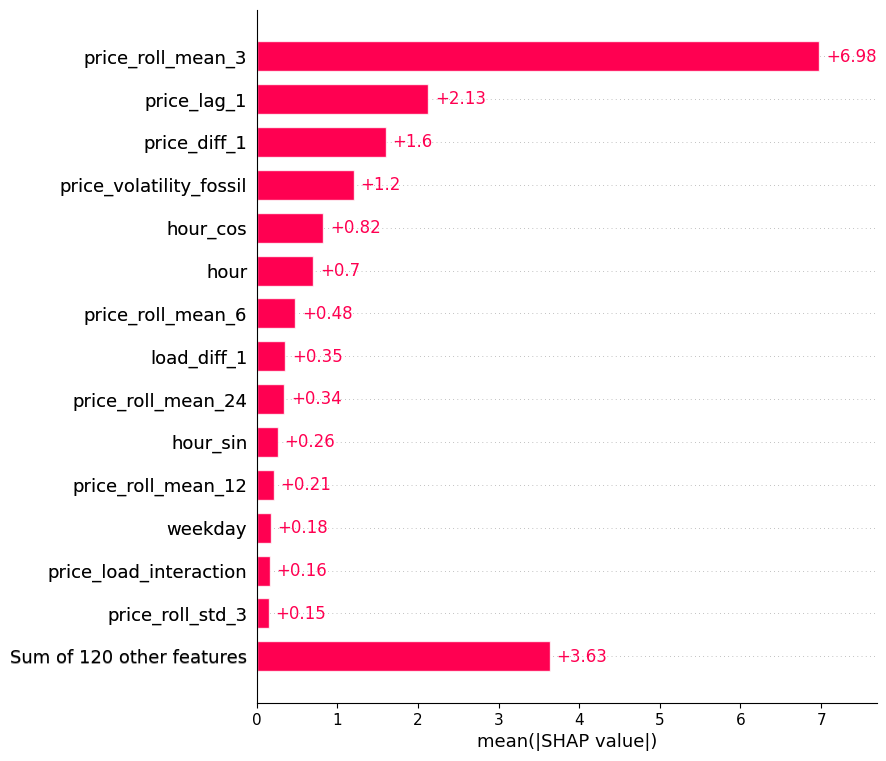

In [32]:
shap.plots.bar(shap_values, max_display=15)

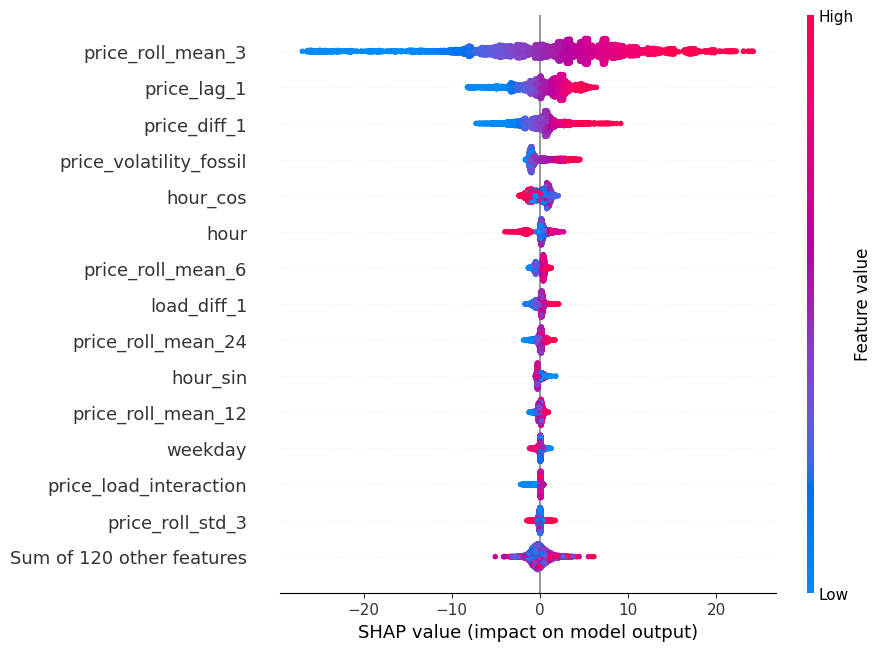

In [33]:
shap.plots.beeswarm(shap_values, max_display=15)

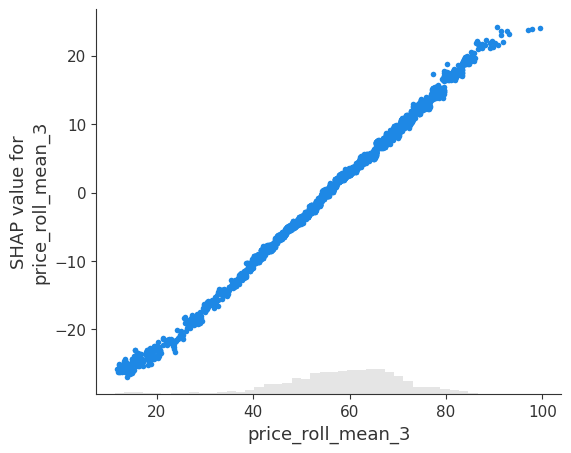

In [35]:
shap.plots.scatter(shap_values[:, "price_roll_mean_3"])


In [79]:
val_pred_mlp = best_model.predict(X_val_scaled)         # MLP için
val_pred_lgbm = best_lgbm.predict(X_val)              # LightGBM için
val_pred_rf = best_rf.predict(X_val)                  # Random Forest için

# Dizi boyutlarını düzleştir (shape uyumu için)
mlp_preds = np.array(val_pred_mlp).reshape(-1)
lgbm_preds = np.array(val_pred_lgbm).reshape(-1)
rf_preds = np.array(val_pred_rf).reshape(-1)
y_true = np.array(y_val).reshape(-1)

# Boyut kontrolü
print("MLP:", mlp_preds.shape)
print("LGBM:", lgbm_preds.shape)
print("RF:", rf_preds.shape)
print("y_val:", y_true.shape)


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP: (5439,)
LGBM: (5439,)
RF: (5439,)
y_val: (5439,)


In [80]:
#ağırlıklı tahmin fonksiyonu
def ensemble_preds(weights):
    w1, w2, w3 = weights
    return w1 * mlp_preds + w2 * lgbm_preds + w3 * rf_preds

#optimize edilecek amaç fonksiyonu (RMSE minimize)
def objective(weights):
    if np.any(weights < 0) or not np.isclose(np.sum(weights), 1):
        return np.inf
    y_pred = ensemble_preds(weights)
    return np.sqrt(mean_squared_error(y_true, y_pred))


Farklı modellerin çıktıları bir araya getirilere ensemble tahminler oluşturulmuştur. Burada amaç, modellerin hata seviyelerine göre ağırlıklarını optimize ederek birleşik tahminin genel hatasını (örneğin RMSE) en aza indirmektir.


In [81]:
from scipy.optimize import minimize

initial_weights = [1/3, 1/3, 1/3]

#ağırlık 0 ile 1 arasında
bounds = [(0, 1)] * 3

#toplam 1 olmalı
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

#en iyi ağırlıklar ve performans
optimal_weights = result.x
ensemble_prediction = ensemble_preds(optimal_weights)
ensemble_rmse = np.sqrt(mean_squared_error(y_true, ensemble_prediction))


In [82]:
print(f"Optimal ağırlıklar: {optimal_weights}")
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")

Optimal ağırlıklar: [0.33333 0.33334 0.33334]
Ensemble RMSE: 94954.3986


In [85]:
import joblib
ensemble_dict = {
    "weights": [0.33333, 0.33334, 0.33334],
    "mlp_preds": mlp_preds,
    "lgbm_preds": lgbm_preds,
    "rf_preds": rf_preds
}
joblib.dump(ensemble_dict, "models/ensemble_info.pkl")


['models/ensemble_info.pkl']

### Genel Sonuç ve Yorum

Bu bölümde, zaman serisi elektrik fiyat tahmini için üç farklı model türüyle deneyler gerçekleştirildi: çok katmanlı yapay sinir ağı (MLP), ağaç tabanlı modellerden LightGBM ve Random Forest. Her model kendi içinde hiperparametre optimizasyonu ile geliştirildi ve hem doğruluk hem de genelleme başarısı açısından değerlendirildi.

Elde edilen tahminler daha sonra birleştirilerek ensemble bir yapı oluşturuldu. Bu yapıda, her modelin çıktısı belirli ağırlıklarla birleştirilerek nihai tahmin elde edildi. Ağırlıklar, doğrulama hatalarını minimize edecek şekilde optimize edildi. Bu yöntem, tek bir modele dayalı tahminlerden daha kararlı ve düşük hatalı sonuçlar verdi.

Modelin hangi özniteliklere ne ölçüde dayandığını görebilmek için SHAP analizi uygulandı.

Sonuç olarak, farklı model türlerinin birlikte kullanıldığı bu yaklaşım sayesinde fiyat tahmin performansı artırıldı. Bu çalışma, zaman serisi probleminde öznitelik mühendisliği, model karşılaştırması ve model birleştirme (ensemble) tekniklerinin birlikte kullanımının etkili sonuçlar verebileceğini göstermiştir.
